# Image Captioning with Flickr8k


**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555
 order.

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate, Lambda, Reshape
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [ ]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.


In [ ]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [ ]:
def get_image_codes(images, batch_size):      
    convnet = MobileNetV2(input_shape=(128,128,3), 
                            include_top=False, 
                            weights='imagenet')
    convnet.summary()

    def batch_gen(images, batch_size):
      i = 0
      while True:
          yield (images[i:batch_size + i] / 255 * 2 - 1)
          i += batch_size

    model = Model(inputs = convnet.input, outputs=convnet.get_layer("Conv_1").output)
    batch_step = len(images)/batch_size
    image_codes = model.predict(batch_gen(images, batch_size), steps=batch_step)
    image_codes = image_codes.reshape(8091, 20480).astype(np.float32)

    return image_codes

image_codes = get_image_codes(images, 200)
print(image_codes.shape)

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [ ]:
import operator
from itertools import islice

max_caption_length = 0
word_dict = {'_': 0}
word_to_idx = {'_': 0}
temp = 0

for cap in captions:
  for i in range(5):
    temp = len(cap[i])
    if(max_caption_length <= temp):
      max_caption_length = temp

    for word in cap[i]:
      if word in word_dict.keys():
        word_dict[word] += 1
      else:
        word_dict[word] = 1
    word_dict['_'] += 1


sorted_d = dict(sorted(word_dict.items(), key=operator.itemgetter(1),reverse=True))
index = 1
for key in sorted_d:
  if key == '_':
    pass
  else:
    word_to_idx[key] = index
    index += 1
idx_to_word = {value:key for key, value in word_to_idx.items()}
num_words = len(word_to_idx)


print("max_caption_length: ", max_caption_length)
print("the 10 most frquend words: ", list(islice(sorted_d.items(), 10)))
print("num_words:", num_words)


max_caption_length:  35
the 10 most frquend words:  [('a', 62986), ('_', 40455), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265)]
num_words: 2992


### Question: 
Do you note a bias in the dataset?

### Answer:
Yes. The majority of the labels are 'man', 'dog' and 'red'. So when an image contains a people/animal or a large proportion of color back/foreground, it's highly likely that the model will predict the wrong label. For example, in question "Predict Test Captions", img6 and img10 respectively points out 'red dress' and 'man playing tennis', which is not the case as the image itself.


# Train/Validation/Test Split

In [ ]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]


# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [ ]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


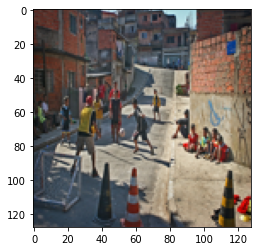

['a', 'group', 'of', 'boys', 'playing', 'street', 'soccer', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





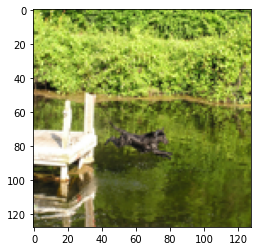

['a', 'black', 'dog', 'jumping', 'from', 'a', 'wooden', 'deck', 'into', 'a', 'lake', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [ ]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()
  
  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [ ]:
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,), name='image_input')
  caption_input = Input(shape=(max_caption_length - 1,), name='caption_input')


  # construct model here
  image_emb = Dense(embedding_dim, activation='relu', name='image_embedding')(image_input)
  image_emb = K.expand_dims(image_emb, axis=1)

  caption_emb = Embedding(num_words, embedding_dim, name='caption_embedding')(caption_input)
  concat = concatenate([image_emb, caption_emb], axis=1)

  lstm = LSTM(lstm_dim, return_sequences=True, dropout=lstm_dropout, name='lstm')(concat)
  output = Dense(num_words, activation='softmax', name="output")(lstm)


  return Model([image_input, caption_input], output)

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

### Question: 
How does the input and output need to be organized? For how many time steps T should the LSTM be unrolled? For each time step, t = 0, . . . , T − 1, which embedding should be input to the LSTM and what should be the target?

### Answer:
(1) There are two parts of input, one is the target image and another one is it's coresponding caption. For image input, we transfer the 20480 feature into 512 dim by a dense layer; for the caption input, we reduce the 2992 one-hot code to 512 dim with a word embedding layer. Then the transformed image and caption are both of 512 dim, we can concatenate them along the time axis to form a 35*512 tensor for LSTM unit.

(2) According to answer(1), the LSTM memories should be unrolled 35 times,T=35.

(3) For each time step t, the output at time t-1 are fed to LSTM. The target is the one-hot matrix of the captions, and the output is a softmaxed probability matrix at last time step. The model calculated loss between probability matrix and one-hot target to optimize the LSTM parameters.

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [ ]:
class Dataiterator():
    '''
      1) Iteration over minibatches using next(); call reset() between epochs to randomly shuffle the data
      2) Access to the entire dataset using all()
    '''
    
    def __init__(self, X, y, batch_size=100):      
        self.X = X 
        self.y = y 
        self.num_data = len(X) # total number of examples
        self.batch_size = batch_size # batch size
        self.reset() # initial: shuffling examples and set index to 0
    
    def __iter__(self): # iterates data
        return self


    def reset(self): # initials
        self.idx = 0
        self.order = np.random.permutation(self.num_data) # shuffling examples by providing randomized ids 
        
    def __next__(self): # return model inputs - outputs per batch
        X_ids = [] # hold ids per batch 
        while len(X_ids) < self.batch_size:
            X_id = self.order[self.idx] # copy random id from initial shuffling
            X_ids.append(X_id)
            self.idx += 1 # 
            if self.idx >= self.num_data: # exception if all examples of data have been seen (iterated)
                self.reset()
                raise StopIteration()
        
        # generate sequence
        images = []
        captions_in = []
        captions_out = []

        for x_id in X_ids:
          image = self.X[x_id]
          image_caption = self.y[x_id]
          caption_in, caption_out = image_caption[:-1], image_caption
          images.append(image)
          captions_in.append(caption_in)
          captions_out.append(caption_out)

        return images, captions_in, captions_out

          
    def all(self): # return all data examples
        return self.X, self.y

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')


batch_size = 100
epochs = 100

model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
            loss=losses.sparse_categorical_crossentropy)

train_steps_epoch = len(train_codes)/batch_size
batch_train_iter = Dataiterator(train_codes, train_y, batch_size)
val_steps_epoch = len(val_codes)/batch_size
batch_val_iter = Dataiterator(val_codes, val_y, batch_size)

def data_gen(batch_iter):
        while True:
            for img, cap_in, cap_out in batch_iter:
              # using named inputs and outputs for the model
              yield ({'image_input': np.array(img), 'caption_input': np.array(cap_in)}, {'output': np.array(cap_out)})
               

model.fit(data_gen(batch_train_iter),
        callbacks=[early_stopping_callback],
        epochs=epochs,
        validation_data=data_gen(batch_val_iter),
        validation_steps=val_steps_epoch,
        steps_per_epoch=train_steps_epoch)


model.save(os.path.join(base_path, 'model.h5'))

Epoch 1/100
305/304 [==============================] - 35s 115ms/step - loss: 2.3752 - val_loss: 1.6792
Epoch 2/100
305/304 [==============================] - 34s 112ms/step - loss: 1.6330 - val_loss: 1.5935
Epoch 3/100
305/304 [==============================] - 34s 112ms/step - loss: 1.5635 - val_loss: 1.5246
Epoch 4/100
305/304 [==============================] - 34s 112ms/step - loss: 1.4851 - val_loss: 1.4430
Epoch 5/100
305/304 [==============================] - 34s 112ms/step - loss: 1.3954 - val_loss: 1.3635
Epoch 6/100
305/304 [==============================] - 34s 112ms/step - loss: 1.3266 - val_loss: 1.3131
Epoch 7/100
305/304 [==============================] - 34s 112ms/step - loss: 1.2739 - val_loss: 1.2617
Epoch 8/100
305/304 [==============================] - 34s 112ms/step - loss: 1.2290 - val_loss: 1.2302
Epoch 9/100
305/304 [==============================] - 34s 112ms/step - loss: 1.1914 - val_loss: 1.2053
Epoch 10/100
305/304 [==============================] - 34s 111m

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [ ]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()


# evaluation on train set
loss = model.evaluate(data_gen(batch_train_iter), steps=train_steps_epoch, verbose=0)
print("Train loss: ", loss)

# # evaluation on validation set
loss = model.evaluate(data_gen(batch_val_iter), steps=val_steps_epoch, verbose=0)
print("Validation loss: ", loss)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 20480)]      0                                            
__________________________________________________________________________________________________
image_embedding (Dense)         (None, 512)          10486272    image_input[0][0]                
__________________________________________________________________________________________________
caption_input (InputLayer)      [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (None, 1, 512)       0           image_embedding[0][0]            
____________________________________________________________________________________________

# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [ ]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  
  # input
  image_input = Input(shape=(code_length,), name='image_input')
  
  # define layers and set weights
  image_emb_layer = Dense(embedding_dim, activation='relu', weights=weights[0], name='image_embedding')
  word_emb_layer = Embedding(num_words, embedding_dim, weights=weights[1], name='word_embedding')
  lstm_layer = LSTM(lstm_dim, return_state=True, dropout=lstm_dropout, weights=weights[2], name='lstm')
  decoder_layer = Dense(num_words, activation='softmax', weights=weights[3], name='decoder_softmax')

  # image embedding
  image_emb = image_emb_layer(image_input)
  image_emb = K.expand_dims(image_emb, axis=1)

  # get initial state (t=0)
  lstm0, h0, c0 = lstm_layer(image_emb)
  state = [h0, c0]
  # first word embedding
  fword = decoder_layer(lstm0)
  fword = K.argmax(fword)
  outputs = [fword]
  fword = K.expand_dims(fword)
  word_emb = word_emb_layer(fword)

  # t>0 takes the embedding of the word predicted at time step t-1 as input
  for k in range(1, max_caption_length):

      lstm, h, c = lstm_layer(word_emb, initial_state=state)
      state = [h, c]
      output = decoder_layer(lstm)
      word = K.argmax(output)
      outputs.append(word)
      word = K.expand_dims(word)
      word_emb = word_emb_layer(word)

  model = Model(inputs=image_input, outputs=outputs, name='decoder')

  return model


# Get the weights from trained model, and put them in a list 'weights'.


# weights for image embedding, word embedding, LSTM, and output layer.
trained_model = load_model(os.path.join(base_path, 'model.h5'))
w_img_emb = trained_model.get_layer('image_embedding').get_weights()
w_word_emb = trained_model.get_layer('caption_embedding').get_weights()
w_lstm = trained_model.get_layer('lstm').get_weights()
w_output = trained_model.get_layer('output').get_weights()

weights = [w_img_emb, w_word_emb, w_lstm, w_output]

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 20480)]      0                                            
__________________________________________________________________________________________________
image_embedding (Dense)         (None, 512)          10486272    image_input[0][0]                
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_1 (Tenso [(None, 1, 512)]     0           image_embedding[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500), (None, 2026000     tf_op_layer_ExpandDims_1[0][0]   
                                                                 word_embedding[0][0]       

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


In [ ]:
def predict_captions(images):
    preds = np.array(decoder.predict(images))
    preds = np.transpose(preds)

    captions = []

    for sequence in preds:
      in_cap= []
      for idx in sequence:
        word = idx_to_word[idx]    
        in_cap.append(word)
        if word == '_':
            break
      captions.append(in_cap[:-1])

    return captions

pred_captions = predict_captions(test_codes)

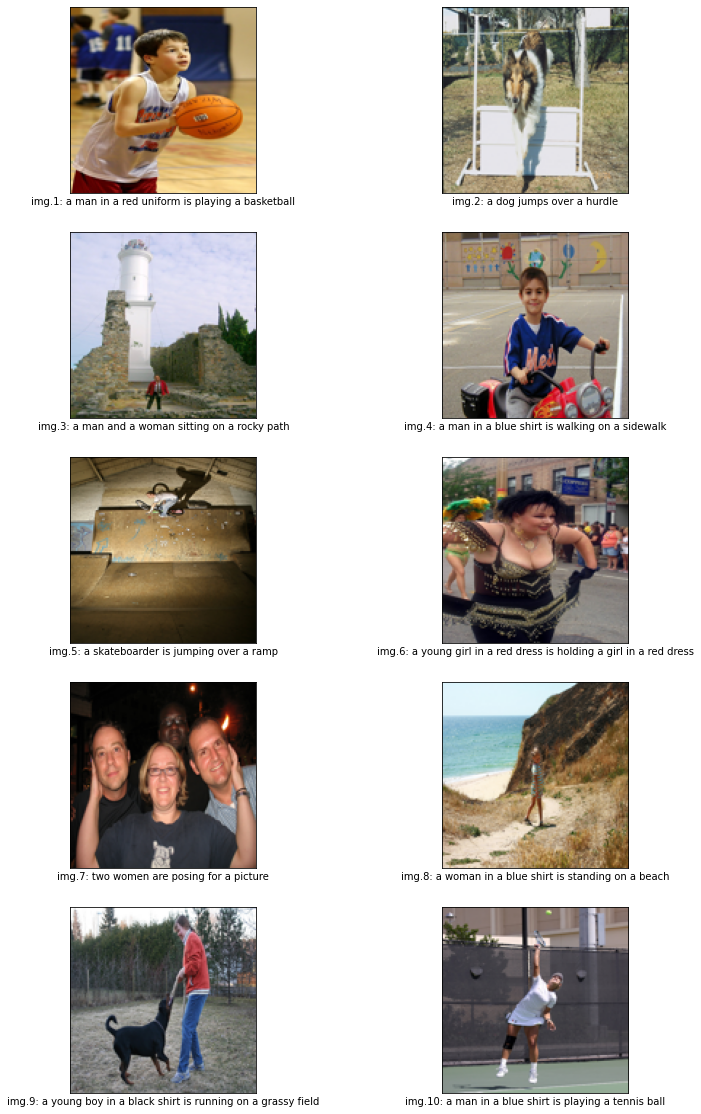

In [ ]:
def show_image_and_captions(images, captions):
  n = images.shape[0]
  captions = ([' '.join(i) for i in captions])

  fig, axes = plt.subplots(5, 2,  figsize=(10,20))
  fig.subplots_adjust(wspace=1)
  axes = axes.flatten()
  i = 1
  for a in axes:
      idx = np.random.randint(0, n)
      a.imshow(images[idx%n])
      a.set_xlabel("img."+ str(i) + ": " + captions[idx])
      a.set_xticks(()), a.set_yticks(())
      i += 1
  plt.show();

show_image_and_captions(test_images, pred_captions)

### Categorize the predictions

Like what shows in Figure 5 in paper[1], we can categorize 10 random images we got into 4 categories such as:

*   Desceibes withou error:  2, 5, 8
*   Desceribes with minor error: 1, 10
*   Somewhat related to the image: 4, 7
*   Unrelated to the image: 3, 6, 9




In [ ]:
from nltk.translate.bleu_score import corpus_bleu

def evaluate_bleu(test_captions, pred_captions):
    actual = test_captions
    predicted = pred_captions

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

evaluate_bleu(test_captions, pred_captions)

BLEU-1: 0.541632
BLEU-2: 0.359517
BLEU-3: 0.267646
BLEU-4: 0.150075
